**Name:** Veljko KOVAC


In [1]:
# %matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
from scipy import ndimage
from scipy import signal
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util

## 1. Loading Data and Pre-processing


In [2]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 4  
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile)
            # convert to grayscale
            img = skimage.color.rgb2gray(img)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

1745
944


Each image is a 19x19 array of pixel values. 

(19, 19)


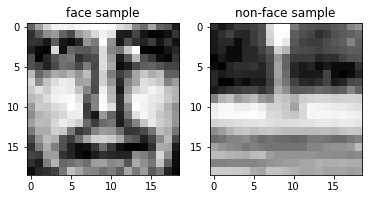

In [3]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(imgdata['train'][0], cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(imgdata['train'][trainclass2start], cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

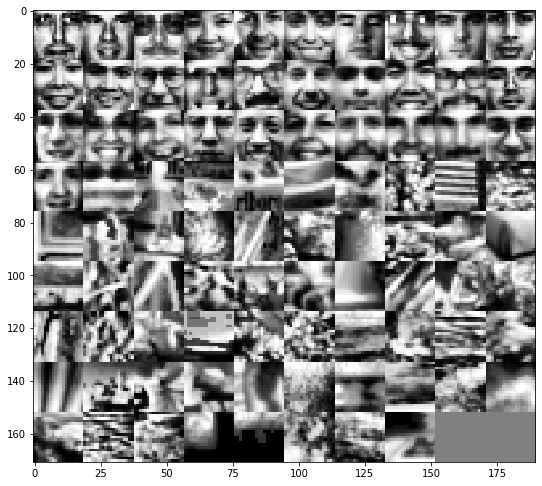

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show a few images
plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata['train'][::20]), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. 

In [5]:
trainX = empty((len(imgdata['train']), prod(imgsize)))
for i,img in enumerate(imgdata['train']):
    trainX[i,:] = ravel(img)
trainY = asarray(classes['train'])  # convert list to numpy array
print(trainX.shape)
print(trainY.shape)

testX = empty((len(imgdata['test']), prod(imgsize)))
for i,img in enumerate(imgdata['test']):
    testX[i,:] = ravel(img)
testY = asarray(classes['test'])  # convert list to numpy array
print(testX.shape)
print(testY.shape)

(1745, 361)
(1745,)
(944, 361)
(944,)


## 2. Detection Using  Pixel Values


In [6]:
# Normalization: sklearn.preprocessing.MinMaxScaler()
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXn = scaler.fit_transform(trainX)   # use training data to fit scaling parameters
testXn  = scaler.transform(testX)        # apply scaling to test data

clfs = {}

In [7]:
# setup all the parameters and models
exps = {
    'svm-lin': {
        'paramgrid': {'C': logspace(-2,3,10)},
        'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,10), 'gamma': logspace(-4,3,10) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,10), 'degree': [2, 3, 4] },
        'clf': svm.SVC(kernel='poly') },
    }

Train each classifier and show the parameters.

In [8]:
for (name,ex) in exps.items():

    svc = ex['clf']
    clfs[name] = model_selection.GridSearchCV(svc,param_grid=ex['paramgrid'],cv=5, verbose=1, n_jobs=-1)
    clfs[name].fit(trainXn,trainY)
    


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished
C:\Users\DELL\Anaconda3\envs\VeljkoEnv\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   38.3s finished
C:\Users\DELL\Anaconda3\envs\VeljkoEnv\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\DELL\Anaconda3\envs\VeljkoEnv\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Calculate the training and test accuracy for the each classifier.

In [9]:
predYtrain = {}
predYtest  = {}
for (name,clf) in clfs.items():
    predYtrain[name] = clfs[name].predict(trainXn)
    predYtest[name] = clfs[name].predict(testXn)
    print("Training Accuracy for "+name+": "+ str(metrics.accuracy_score(predYtrain[name],trainY)))
    print("Testing Accuracy for "+name+": "+ str(metrics.accuracy_score(predYtest[name],testY)))       

Training Accuracy for svm-lin: 0.9833810888252149
Testing Accuracy for svm-lin: 0.6430084745762712
Training Accuracy for svm-rbf: 1.0
Testing Accuracy for svm-rbf: 0.6578389830508474
Training Accuracy for svm-poly: 1.0
Testing Accuracy for svm-poly: 0.6620762711864406


In [10]:
predY = predYtest['svm-poly']
#adaclf = clfs['ada'].best_estimator_
svmclf_rbf = clfs['svm-rbf'].best_estimator_
svmclf_poly = clfs['svm-poly'].best_estimator_
#rfclf  = clfs['rf'].best_estimator_

### Error analysis
The accuracy only tells part of the classifier's performance. We can also look at the different types of errors that the classifier makes:
- _True Positive (TP)_: classifier correctly said face
- _True Negative (TN)_: classifier correctly said non-face
- _False Positive (FP)_: classifier said face, but not a face
- _False Negative (FN)_: classifier said non-face, but was a face

We can then look at the _true positive rate_ and the _false positive rate_.
- _true positive rate (TPR)_: proportion of true faces that were correctly detected
- _false positive rate (FPR)_: proportion of non-faces that were mis-classified as faces.

Calculate the TPR and FPR of your classifiers.

In [11]:
# predY is the prediction from the classifier

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = count_nonzero(testY[Pind] == predY[Pind])
FP = count_nonzero(testY[Pind] != predY[Pind])
TN = count_nonzero(testY[Nind] == predY[Nind])
FN = count_nonzero(testY[Nind] != predY[Nind])

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)
#ERROR HERE

TP= 154
FP= 318
TN= 471
FN= 1
TPR= 0.9935483870967742
FPR= 0.40304182509505704


For kernel SVM, we can look at the support vectors to see what the classifier finds difficult.

num support vectors: 307


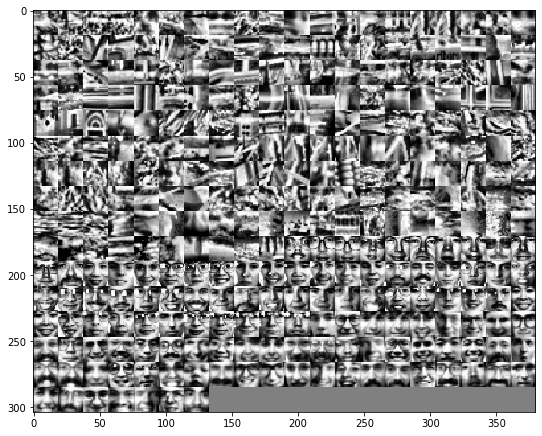

In [12]:
# svmclf is the trained SVM classifier

print("num support vectors:", len(svmclf_poly.support_vectors_))
si  = svmclf_poly.support_  # get indicies of support vectors

# get all the patches for each support vector
simg = [ imgdata['train'][i] for i in si ]

# make montage
outimg = image_montage(simg, maxw=20)

plt.figure(figsize=(9,9))
plt.imshow(outimg, cmap='gray', interpolation='nearest')

## 3. Detection using Image Feature

### Image Feature Extraction
The detection performance is not that good using pixel values. The problem is that we are using the raw pixel values as features, so it is difficult for the classifier to interpret larger structures of the face that might be important.  To fix the problem, we will extract features from the image using a set of filters.

The filters are a sets of black and white boxes that respond to similar structures in the image.  After applying the filters to the image, the filter response map is aggregated over a 4x4 window.  Hence each filter produces a 5x5 feature response.  Since there are 4 filters, then the feature vector is 100 dimensions.

In [13]:
def extract_features(imgs, doplot=False):
    # the filter layout
    lay = [array([-1,1]), array([-1,1,-1]),  
               array([[1],[-1]]), array([[-1],[1],[-1]])]
    sc=8            # size of each filter patch
    poolmode = 'i'  # pooling mode (interpolate)
    cmode = 'same'  # convolution mode
    brick = ones((sc,sc))  # filter patch
    ks = []
    for l in lay:
        tmp = [brick*i for i in l]
        if (l.ndim==1):
            k = hstack(tmp)
        else:
            k = vstack(tmp)
        ks.append(k)

    # get the filter response size
    if (poolmode=='max') or (poolmode=='absmax'):
        tmpimg = maxpool(maxpool(imgs[0]))
    else:
        tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)        
    fs = prod(tmpimg.shape)
    
    # get the total feature length
    fst = fs*len(ks)

    # filter the images
    X  = empty((len(imgs), fst))
    for i,img in enumerate(imgs):
        x = empty(fst)

        # for each filter
        for j,th in enumerate(ks):
            # filter the image
            imgk = signal.convolve(img, ks[j], mode=cmode)
            
            # do pooling
            if poolmode == 'maxabs':
                mimg = maxpool(maxpool(abs(imgk)))
            elif poolmode == 'max':
                mimg = maxpool(maxpool(imgk))
            else:
                mimg = ndimage.interpolation.zoom(imgk, 0.25)
    
            # put responses into feature vector
            x[(j*fs):(j+1)*fs] = ravel(mimg)
               
            if (doplot):             
                plt.subplot(3,len(ks),j+1)
                plt.imshow(ks[j], cmap='gray', interpolation='nearest')
                plt.title("filter " + str(j))
                plt.subplot(3,len(ks),len(ks)+j+1)
                plt.imshow(imgk, cmap='gray', interpolation='nearest')
                plt.title("filtered image")
                plt.subplot(3,len(ks),2*len(ks)+j+1)
                plt.imshow(mimg, cmap='gray', interpolation='nearest')
                plt.title("image features")
        X[i,:] = x
    
    return X

C:\Users\DELL\Anaconda3\envs\VeljkoEnv\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


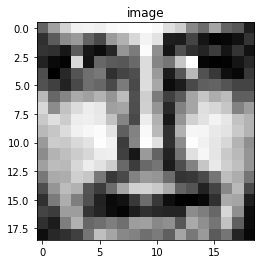

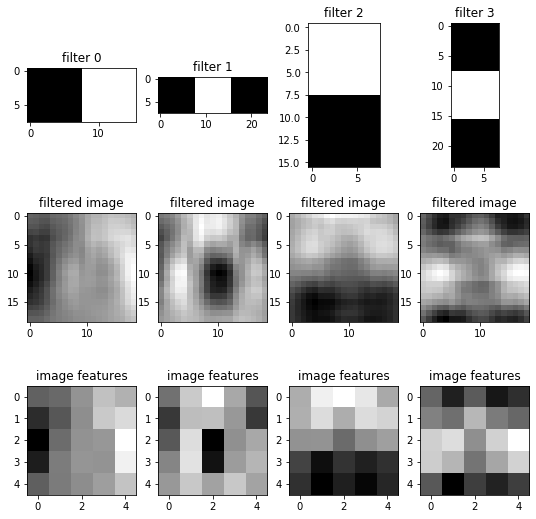

In [14]:
# new features
img = imgdata['train'][0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("image")
plt.figure(figsize=(9,9))
extract_features([img], doplot=True);

In [15]:
trainXf = extract_features(imgdata['train'])
print(trainXf.shape)
testXf = extract_features(imgdata['test'])
print(testXf.shape)

(1745, 100)
(944, 100)


### Detection 
Training with AdaBoost and SVM classifiers on the image feature data.

In [16]:
### Nomalization
scalerf = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXfn = scalerf.fit_transform(trainXf)   # use training data to fit scaling parameters
testXfn  = scalerf.transform(testXf)        # apply scaling to test data

clfs2 = {}

In [17]:
# setup all the parameters and models
exps = {
    'svm-lin': {
        'paramgrid': {'C': logspace(-2,3,10)},
        'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,10), 'gamma': logspace(-4,3,10) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,10), 'degree': [2, 3, 4] },
        'clf': svm.SVC(kernel='poly') },       
    }
clfs2 = {}

In [18]:
for (name,ex) in exps.items():
    svc = ex['clf']
    clfs2[name] = model_selection.GridSearchCV(svc,param_grid=ex['paramgrid'],cv=5, verbose=1, n_jobs=-1)
    clfs2[name].fit(trainXfn,trainY)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   51.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   10.8s finished
C:\Users\DELL\Anaconda3\envs\VeljkoEnv\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Calculate the training and test accuracy for the each classifier.

In [19]:
predYtrain = {}
predYtest  = {}
for (name,clf) in clfs2.items():
    predYtrain[name] = clfs2[name].predict(trainXfn)
    predYtest[name] = clfs2[name].predict(testXfn)
    print("Training Accuracy for "+name+": "+ str(metrics.accuracy_score(predYtrain[name],trainY)))
    print("Testing Accuracy for "+name+": "+ str(metrics.accuracy_score(predYtest[name],testY)))

Training Accuracy for svm-lin: 0.9621776504297994
Testing Accuracy for svm-lin: 0.7129237288135594
Training Accuracy for svm-rbf: 0.9977077363896848
Testing Accuracy for svm-rbf: 0.7341101694915254
Training Accuracy for svm-poly: 0.9856733524355301
Testing Accuracy for svm-poly: 0.777542372881356


In [20]:
predY2 = predYtest['svm-rbf']
bestclf = clfs2['svm-rbf']

### Error Analysis
Similar to before, repeat the error analysis for the new classifiers.

In [21]:
## TP, FN, TN, TP, TPR, FPR
Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = count_nonzero(testY[Pind] == predY2[Pind])
FP = count_nonzero(testY[Pind] != predY2[Pind])
TN = count_nonzero(testY[Nind] == predY2[Nind])
FN = count_nonzero(testY[Nind] != predY2[Nind])

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)
#ERROR HERE

TP= 234
FP= 238
TN= 459
FN= 13
TPR= 0.9473684210526315
FPR= 0.34146341463414637


# Test image
Now let us try your face detector on a real image.

In [22]:
fname = "nasa-small.png"

(210, 480)


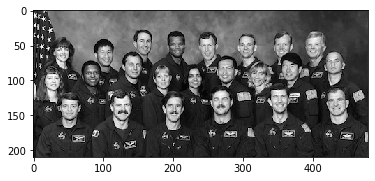

In [23]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
testimg = skimage.color.rgb2gray(testimg3)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [24]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3]))
print(patches2.shape )

# histogram equalize patches (improves contrast)
patches3 = empty(patches2.shape)
for i in range(patches2.shape[0]):
    patches3[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])

# extract features
newXf = extract_features(patches3)

(5568, 19, 19)


C:\Users\DELL\Anaconda3\envs\VeljkoEnv\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Now predict using your classifier.  The extracted features are in `newXf`.

In [25]:
newXfn = scalerf.transform(newXf)   # use training data to fit scaling parameters
prednewY = clfs2['svm-rbf'].predict(newXfn)

Now we we will view the results on the image. 

(-0.5, 479.5, 209.5, -0.5)

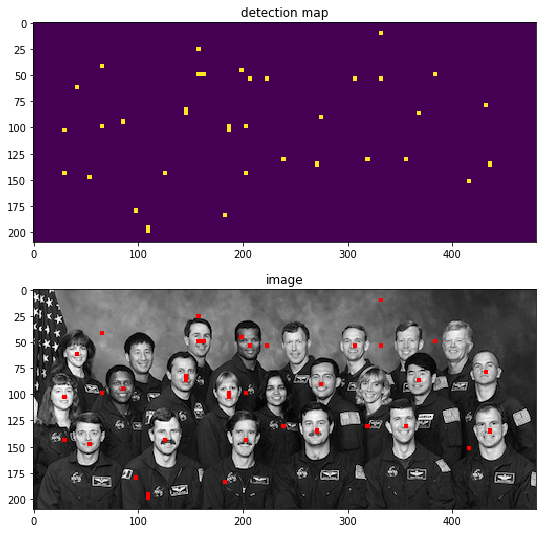

In [26]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')